# Tensorflow Slim
In this notebook we will use tensorflow's high level API (wrapper) module called `slim` to re-do training of CNN for MNIST data set. There is even more popular wrapper called `keras`. Both toolkits provide simple functions for us to easily build a complex computational graph.

In the previous MNIST example, we defined convolution and fully-connected layers in a pedantic way by defining weights, bias, and even matrix multiplication by hand. It was to see the internal calculation explicitly. But doing so is a) tiring and b) increases a chance of making a mistake. Now that we understand how the internals work, let's use high level APIs.

In [1]:
# Import tensorflow
import tensorflow as tf
# Import tensorflow's MNIST data handle
from tensorflow.examples.tutorials.mnist import input_data
mnist = input_data.read_data_sets('MNIST_data', one_hot=True)

Extracting MNIST_data/train-images-idx3-ubyte.gz
Extracting MNIST_data/train-labels-idx1-ubyte.gz
Extracting MNIST_data/t10k-images-idx3-ubyte.gz
Extracting MNIST_data/t10k-labels-idx1-ubyte.gz


## Define the network
First, let's define placeholders for input data, labels, and drop-out fraction. This part is identical to the last MNIST training tutorial.

In [2]:
# Network inputs
with tf.variable_scope('input'):
    images    = tf.placeholder(tf.float32, shape=[None, 784])
    labels    = tf.placeholder(tf.float32, shape=[None, 10])
    keep_prob = tf.placeholder(tf.float32)
    
    image2d   = tf.reshape(images, [-1, 28, 28, 1])
    # Record a random 10 samples of images in monitoring
    tf.summary.image('images',image2d,10)

Secondly, we define a function to build the network using `slim`.

In [3]:
import tensorflow.contrib.slim as slim

# Design a network
def build(input_tensor, debug=False):

    # Convolution 1
    conv1 = slim.conv2d     (input_tensor, 32, 5, scope='conv1'  )
    # Pooling 1
    pool1 = slim.max_pool2d (conv1,            2, scope='pool1'  )
    # Convolution 2
    conv2 = slim.conv2d     (pool1,        64, 5, scope='conv2'  )
    # Pooling 2
    pool2 = slim.max_pool2d (conv2,            2, scope='pool2'  )
    # Flatten
    flat  = slim.flatten    (pool2,               scope='flatten')
    # FC1
    fc1   = slim.fully_connected (flat,  1024,    scope='fc1'    )
    with tf.variable_scope('drop_out'):
        drop = slim.dropout (fc1, keep_prob,      scope='dropout')
    # FC2
    fc2   = slim.fully_connected (drop,    10,    scope='fc2', activation_fn=None)
    
    # Dimension check if debug is True
    if debug:
        print('Input shape:', input_tensor.shape )
        print('After conv1:', conv1.shape        )
        print('After pool1:', pool1.shape        )
        print('After conv2:', conv2.shape        )
        print('After pool2:', pool2.shape        )
        print('After fc1  :', fc1.shape          )
        print('After fc2  :', fc2.shape          )

    return fc2

... and let's actually build it! Enable `debug` boolean to print out the dimensions.

In [4]:
net = build(image2d, debug=True)

('Input shape:', TensorShape([Dimension(None), Dimension(28), Dimension(28), Dimension(1)]))
('After conv1:', TensorShape([Dimension(None), Dimension(28), Dimension(28), Dimension(32)]))
('After pool1:', TensorShape([Dimension(None), Dimension(14), Dimension(14), Dimension(32)]))
('After conv2:', TensorShape([Dimension(None), Dimension(14), Dimension(14), Dimension(64)]))
('After pool2:', TensorShape([Dimension(None), Dimension(7), Dimension(7), Dimension(64)]))
('After fc1  :', TensorShape([Dimension(None), Dimension(1024)]))
('After fc2  :', TensorShape([Dimension(None), Dimension(10)]))


## Add all monitoring variables in 1 shot
You might wonder "wait, how are variables monitored in Tensorboard?" Great point: last time we explicitly added all variables we defined to `tf.summary` by hand. This time, variables are internally defined within `slim` functions. So we are not adding them by hand. Fortunately there's an easy way to add all trainable variables to tensorboard log.

In [5]:
tf.contrib.layers.summarize_collection(tf.GraphKeys.TRAINABLE_VARIABLES)

[<tf.Tensor 'conv1/weights_summary:0' shape=() dtype=string>,
 <tf.Tensor 'conv1/biases_summary:0' shape=() dtype=string>,
 <tf.Tensor 'conv2/weights_summary:0' shape=() dtype=string>,
 <tf.Tensor 'conv2/biases_summary:0' shape=() dtype=string>,
 <tf.Tensor 'fc1/weights_summary:0' shape=() dtype=string>,
 <tf.Tensor 'fc1/biases_summary:0' shape=() dtype=string>,
 <tf.Tensor 'fc2/weights_summary:0' shape=() dtype=string>,
 <tf.Tensor 'fc2/biases_summary:0' shape=() dtype=string>]

## Define loss and optimizer
Thirdly, define training step, loss, and accuracy. This part is also identical to the last MNIST training tutorial.

In [6]:
# Train operations
with tf.variable_scope("train"):
    loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(labels=labels, logits=net))
    train_step = tf.train.AdamOptimizer(1e-4).minimize(loss)
    
    correct_prediction = tf.equal(tf.argmax(net, 1), tf.argmax(labels, 1))
    accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))
    
    # Monitor these loss and accuracy during training
    tf.summary.scalar('loss',loss)
    tf.summary.scalar('accuracy',accuracy)

## Create a session and tensorboard log
Final step before training. Define a session and tensorboard log writer. Again, identical to the last tutorial.

In [7]:
# Define a session
sess = tf.InteractiveSession()

# Create log monitor
import os
if not os.path.isdir('tb_log'): os.makedirs('tb_log')
log_writer = tf.summary.FileWriter('tb_log')
log_writer.add_graph(sess.graph)
summary_op = tf.summary.merge_all()

## Train

In [8]:
# Let's time this
import time
start = time.time()

# Ready! initialize and train for 5000 steps
sess.run(tf.global_variables_initializer())
for i in range(2000):

    # Fetch data of 50 images
    batch = mnist.train.next_batch(50)

    # Every 100 steps, compute & print the accuracy of the network's prediction
    if i % 100 == 0:
        train_accuracy = sess.run(accuracy, feed_dict={images: batch[0], labels: batch[1], keep_prob: 1.0})
        print('step %d, training accuracy %g' % (i, train_accuracy))
    
    # Every 20 steps, compute & record tensorboard log
    if i % 20 == 0:
        s = sess.run(summary_op, feed_dict={images: batch[0], labels: batch[1], keep_prob: 1.0})
        log_writer.add_summary(s,i)

    # Every step run training!
    sess.run(train_step, feed_dict={images: batch[0], labels: batch[1], keep_prob: 0.5})

# Compute & print out the final accuracy
print('test accuracy %g' % sess.run(accuracy, feed_dict={images: mnist.test.images, labels: mnist.test.labels, keep_prob: 1.0}))
print(time.time() - start)

step 0, training accuracy 0.1
step 100, training accuracy 0.84
step 200, training accuracy 0.94
step 300, training accuracy 0.94
step 400, training accuracy 0.94
step 500, training accuracy 0.96
step 600, training accuracy 0.98
step 700, training accuracy 0.88
step 800, training accuracy 0.98
step 900, training accuracy 0.96
step 1000, training accuracy 1
step 1100, training accuracy 0.98
step 1200, training accuracy 1
step 1300, training accuracy 0.96
step 1400, training accuracy 0.98
step 1500, training accuracy 0.94
step 1600, training accuracy 1
step 1700, training accuracy 0.96
step 1800, training accuracy 1
step 1900, training accuracy 1
test accuracy 0.9811
23.9017009735


Both the performance and the training time should be roughly the same. 

## Analysis
Finally, let's dump 10 images and check network's performance visually.

Prediction 7 with softmax prob 0.999677 


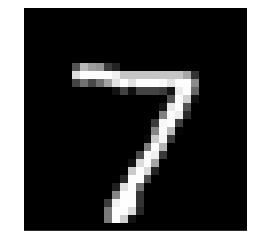

Prediction 2 with softmax prob 0.999726 


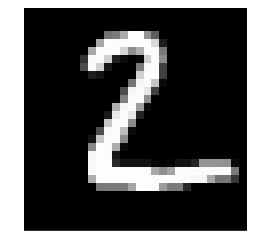

Prediction 1 with softmax prob 0.996753 


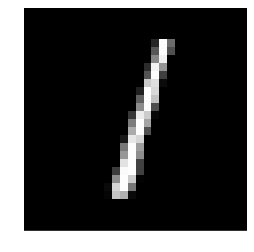

Prediction 0 with softmax prob 0.999797 


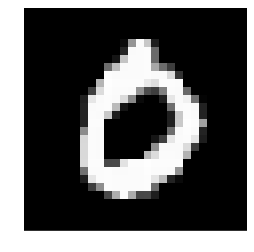

Prediction 4 with softmax prob 0.99903 


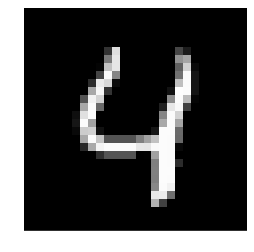

Prediction 1 with softmax prob 0.998879 


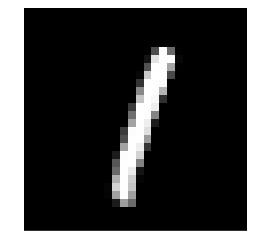

Prediction 4 with softmax prob 0.994752 


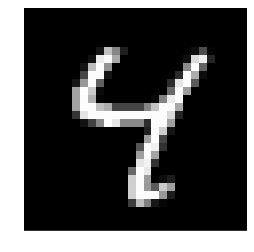

Prediction 9 with softmax prob 0.961704 


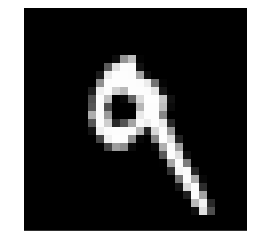

Prediction 5 with softmax prob 0.991089 


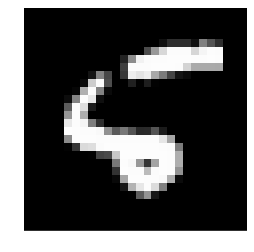

Prediction 9 with softmax prob 0.986517 


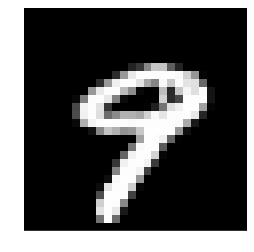

In [9]:
# Define operations: a softmax probability, and the prediction by the network
with tf.variable_scope('analysis'):
    softmax = tf.nn.softmax(logits=net)
    prediction_label = tf.argmax(net,1)

import numpy as np
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
# Dump some output images
prob_array, pred_label, = sess.run([softmax,prediction_label],feed_dict={images: mnist.test.images,keep_prob:1.0})
for index in xrange(10):
    print 'Prediction\033[91m',pred_label[index],'\033[00mwith softmax prob\033[94m',prob_array[index][pred_label[index]],'\033[00m'
    plt.imshow(mnist.test.images[index].reshape([28,28]).astype(np.float32),cmap='gray',interpolation='none')
    plt.axis('off')
    plt.show()

## Closing remark
In this notebook, we used `slim`, tensorflow's native high level APIs to construct a computational graph. It greatly simplified the network construction task for us. I hope it was an educational comparison between this notebook and the last MNIST tutorial notebook where we defined network layers in a pedantic way (i.e. by hand).